In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pyodbc

In [4]:
# parametros db
server = 'localhost'
database = 'customeranalysis'
driver = 'ODBC Driver 17 for SQL Server'
databasecon = f'mssql://@{server}/{database}?driver={driver}'

engine = create_engine(databasecon)
con = engine.connect()

In [10]:
#Sql para dataframe pandas
query1 = pd.read_sql_query('''SELECT
	DATEPART(YY,OrderDate) as data_venda,
	sum(Quantity) as quantidade_vendas
	FROM dbo.sales
    GROUP BY 
	DATEPART(YY,OrderDate)''' , con)
#------------------------------------------------------
query2 = pd.read_sql_query('''SELECT
    st.SquareMeters AS Metros_quadrados,
    st.StoreKey as Codigo,
    AVG(sales.UnitPrice) AS Media_preco,
    SUM(Quantity * UnitPrice) AS Faturamento
    FROM sales
    LEFT JOIN dbo.store as st
        on sales.StoreKey = st.StoreKey
    GROUP BY 
    st.SquareMeters ,
    st.StoreKey
    ORDER BY st.StoreKey''', con)
#------------------------------------------------------
query3 = pd.read_sql_query('''WITH ResumoVendasLoja AS (
        SELECT
            StoreKey as Loja,
            DATEPART(YY, OrderDate) as Ano,
            SUM(Quantity) as quantidade_vendas
        FROM dbo.sales
        GROUP BY
            StoreKey,
            DATEPART(YY, OrderDate)
        )
        SELECT 
        Loja,
        Ano,
        quantidade_vendas,
        SUM(quantidade_vendas) OVER(PARTITION BY Loja ORDER BY Ano) AS Acumulado_vendas,
        quantidade_vendas - LAG(quantidade_vendas,1,0) OVER(PARTITION BY Loja ORDER BY Ano) AS Diferença_vendas
        FROM ResumoVendasLoja;''' , con)
#------------------------------------------------------
query4 = pd.read_sql_query(''' ;WITH CurvaABC1 as(
        SELECT
        sales.ProductKey AS Chave_produto,
        sum(sales.UnitPrice * sales.Quantity) AS Faturamento,
        product.ProductName as Nome_produto
        FROM sales
            LEFT JOIN [dbo].[product]
                ON product.ProductKey = sales.ProductKey
        GROUP BY 
            sales.ProductKey,
            product.ProductName
        ),
        CurvaABC2 AS (
            SELECT
                Nome_produto,
                Faturamento,
                SUM(Faturamento) OVER () AS Total,
                Faturamento / SUM(Faturamento) OVER () AS Porcentagem
            FROM CurvaABC1
        ),

        CurvaABC3 AS (
        SELECT
            Nome_produto,
            Faturamento,
            Total,
            Porcentagem,
            SUM(Porcentagem) OVER(ORDER BY Faturamento DESC) * 100 AS Acumulado_vendas
        FROM CurvaABC2
        )
            SELECT
            Nome_produto,
            Faturamento,
            Total,
            Porcentagem,
            Acumulado_vendas,
            CASE WHEN 
                Acumulado_vendas <= 70 THEN 'A'
                WHEN Acumulado_vendas <= 95 THEN 'B'
                ELSE 'C'
            END AS CurvaABC
        FROM CurvaABC3
        ORDER BY
            Porcentagem DESC
        ;''' , con)


#### Vendas por Ano

<Axes: title={'center': 'Faturamento 2015-2024'}, xlabel='data_venda', ylabel='quantidade_vendas'>

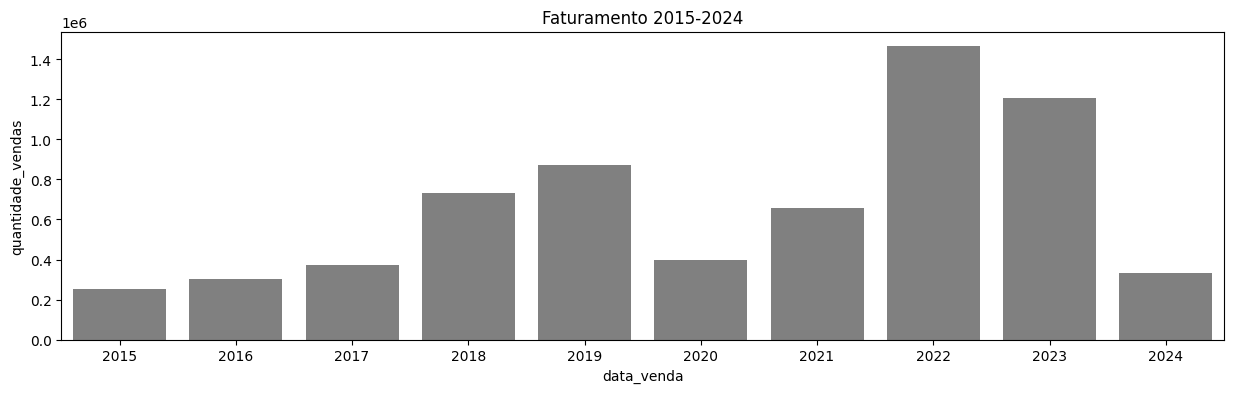

In [38]:
plt.figure(figsize=[15,4])
plt.title('Faturamento 2015-2024')
sns.barplot(data=query1, x="data_venda", y="quantidade_vendas",color='Grey')

#### Lojas por faturamento e m²

<Axes: title={'center': 'Correlação M² e Faturamento'}, xlabel='Metros_quadrados', ylabel='Media_preco'>

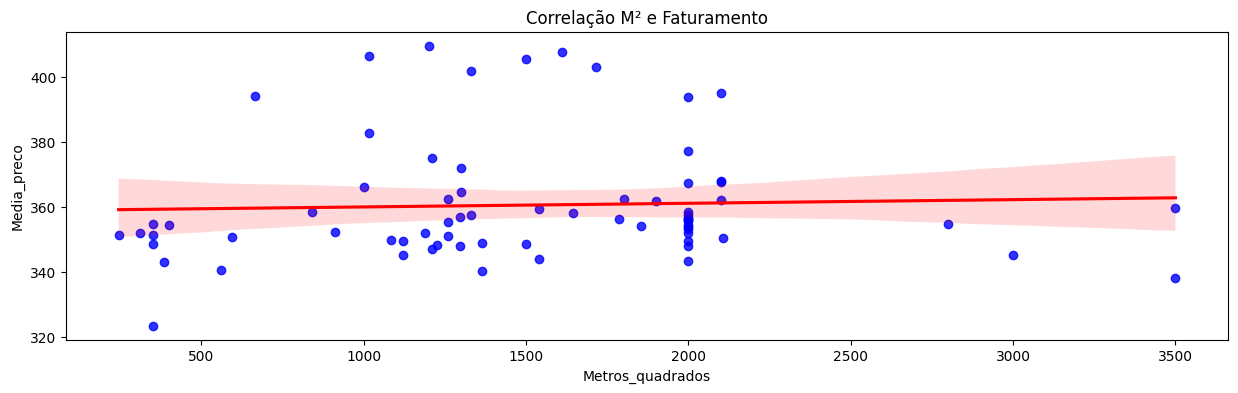

In [42]:
plt.figure(figsize=[15,4])
plt.title('Correlação M² e Faturamento')
sns.regplot(data=query2, x="Metros_quadrados", y="Media_preco", scatter_kws={"color": "blue"}, line_kws={"color": "red"})

<Axes: title={'center': 'Correlação M² e Faturamento'}, xlabel='Metros_quadrados', ylabel='Faturamento'>

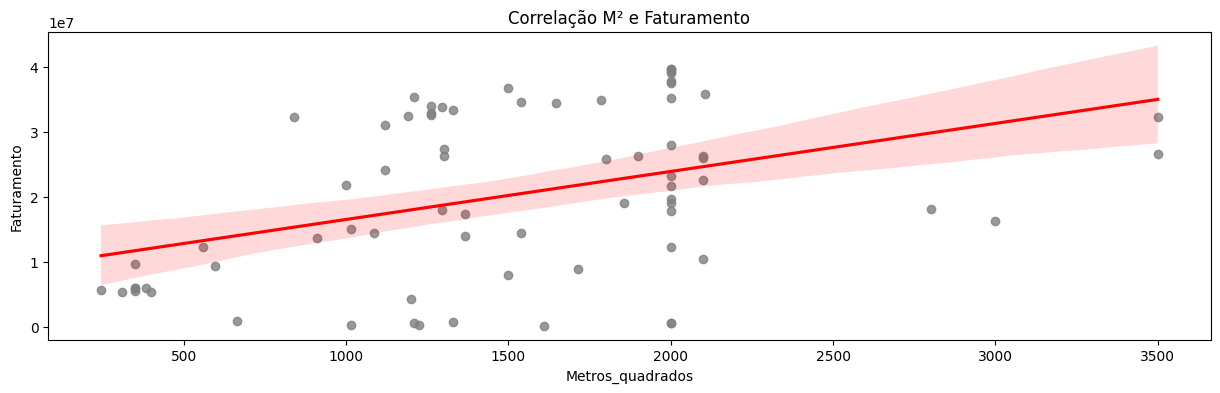

In [43]:
plt.figure(figsize=[15,4])
plt.title('Correlação M² e Faturamento')
sns.regplot(data=query2, x="Metros_quadrados", y="Faturamento", scatter_kws={"color": "grey"}, line_kws={"color": "red"})

#### Diferença de vendas entre os anos

<Axes: title={'center': 'Faturamento 2015-2024'}, xlabel='Ano', ylabel='Diferença_vendas'>

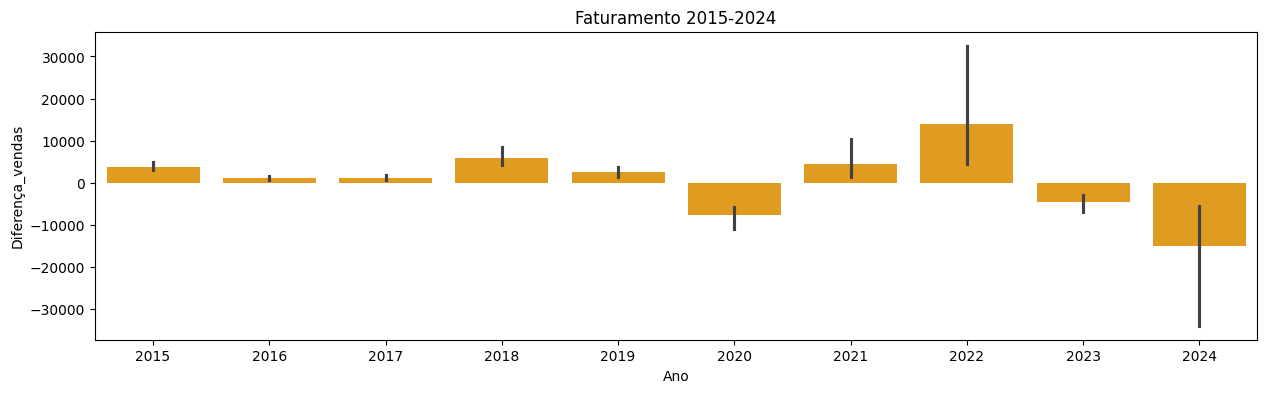

In [49]:
plt.figure(figsize=[15,4])
plt.title('Faturamento 2015-2024')
sns.barplot(data=query3, x="Ano", y="Diferença_vendas",color='orange')

#### Curva ABC Produtos

C:\Users\walte\AppData\Local\Temp\ipykernel_9384\4270443138.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Nome_produto", y="Faturamento", data=query4, ci=None)
C:\Users\walte\AppData\Local\Temp\ipykernel_9384\4270443138.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="Nome_produto", y="Acumulado_vendas", data=query4, estimator="mean", ci=None, marker="o", color="red")


<Axes: xlabel='Nome_produto', ylabel='Faturamento'>

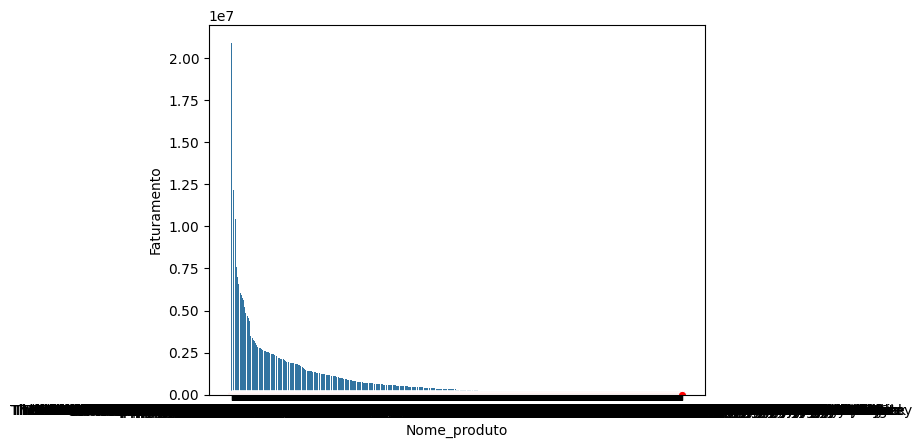

In [53]:
# Criando um gráfico de barras
sns.barplot(x="Nome_produto", y="Faturamento", data=query4, ci=None)

# Adicionando uma linha de tendência (média por dia)
sns.lineplot(x="Nome_produto", y="Acumulado_vendas", data=query4, estimator="mean", ci=None, marker="o", color="red")

In [50]:
query4

,Nome_produto,Faturamento,Total,Porcentagem,Acumulado_vendas,CurvaABC
0,Adventure Works Desktop PC2.33 XD233 White,2.093573e+07,2.262085e+09,9.255060e-03,0.925506,A
1,Adventure Works Desktop PC2.33 XD233 Black,2.025113e+07,2.262085e+09,8.952420e-03,1.820748,A
2,Adventure Works Desktop PC2.33 XD233 Silver,1.995559e+07,2.262085e+09,8.821768e-03,2.702925,A
3,Adventure Works Desktop PC2.33 XD233 Brown,1.971915e+07,2.262085e+09,8.717247e-03,3.574649,A
4,WWI Desktop PC2.33 X2330 Silver,1.960365e+07,2.262085e+09,8.666187e-03,4.441268,A
...,...,...,...,...,...,...
2512,Litware 80mm Dual Ball Bearing Case Fan E1001 ...,2.238664e+03,2.262085e+09,9.896463e-07,99.999760,C
2513,SV USB Data Cable E600 Grey,1.446375e+03,2.262085e+09,6.393992e-07,99.999824,C
2514,SV USB Data Cable E600 Pink,1.405050e+03,2.262085e+09,6.211306e-07,99.999886,C
2515,SV USB Data Cable E600 Black,1.319550e+03,2.262085e+09,5.833336e-07,99.999944,C
